# Trabajo Mineria

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
sueldo_df = pd.read_csv("sueldo_minimo_chile.csv")#2009 a 2025
desempleo_df = pd.read_csv("Tasa desempleo.csv")#2010 a 2024 trimestres
empleo_df = pd.read_csv("tasa_empleo_formal_etario.csv");#2010 a 2024 trimestres
empleo_informal_df = pd.read_csv("tasa_empleo_informal_etario.csv");#2017 a 2024 trimestres
sueldo_nominal = pd.read_csv("sueldo_nominal_etario.csv");#anual 2010 a 2022
#sueldo_real = pd.read_csv("sueldo_real_etario.csv");#anual 2010 a 2022
#pib = pd.read_csv("Pib.csv")#anual 1960 a 2023
#pib_crecimiento=pd.read_csv("Pib_Crecimiento%.csv")#anual 1961 a 2023
pib_percapita=pd.read_csv("Pib_percapita.csv")#anual 1960 a 2023 el más util
dolar=pd.read_csv("dolar.csv",sep=";")#mensual 2007 a 2025
ipc=pd.read_csv("ipc.csv",encoding="latin",sep=";")#mensual 2010 a 2025 2023=100

lista=["Trimestre Móvil","Tramo etario", "Value"]
merge=["Trimestre Móvil","Tramo etario"]

df_empleabilidad= pd.merge(empleo_df[["Trimestre Móvil","Tramo etario", "Value"]], desempleo_df[["Trimestre Móvil","Tramo etario", "Value"]], on=["Trimestre Móvil","Tramo etario"], how="inner")
df_empleabilidad=df_empleabilidad.rename(columns={"Value_x": "Tasa de empleo", "Value_y": "Tasa de desempleo"})
df_empleabilidad["Año"] = df_empleabilidad["Trimestre Móvil"].str.extract(r"(\d{4})").astype(int)
meses = {
  "ene": 1,
  "feb": 2,
  "mar": 3,
  "abr": 4,
  "may": 5,
  "jun": 6,
  "jul": 7,
  "ago": 8,
  "sep": 9,
  "oct": 10,
  "nov": 11,
  "dic": 12 
}
df_empleabilidad["Mes"]=df_empleabilidad["Trimestre Móvil"].str.slice(start=9, stop=12).replace(meses)
df_empleabilidad.loc[df_empleabilidad['Mes'] == 1, 'Año'] = df_empleabilidad[df_empleabilidad["Mes"]==1]["Año"]+1
sueldo_df["fecha"]=sueldo_df["fecha"].astype('datetime64[s]')
date_range = pd.date_range(start="2009-07-01", end="2025-05-01", freq='MS')
sueldo_df = sueldo_df.set_index('fecha').reindex(date_range).reset_index().ffill().rename(columns={"index": "fecha"})
sueldo_df['Año'] = sueldo_df['fecha'].astype('datetime64[s]').dt.year
sueldo_df['Mes'] = sueldo_df['fecha'].astype('datetime64[s]').dt.month
sueldo_df=sueldo_df.rename(columns={"monto_clp": "Sueldo minimo"})
df_empleabilidad= pd.merge(df_empleabilidad[["Año","Mes","Tramo etario","Tasa de empleo","Tasa de desempleo"]], sueldo_df[["Año","Mes","Sueldo minimo"]], on=["Año","Mes"], how="inner")
df_empleabilidad= pd.merge(df_empleabilidad, ipc[["Año","Mes","Índice"]], on=["Año","Mes"], how="inner")
dolar["Mes"]=dolar["Periodo"].str.slice(start=0, stop=3).replace(meses)
dolar["Año"]=dolar["Periodo"].str.extract(r"(\d{4})").astype(int)
df_empleabilidad= pd.merge(df_empleabilidad, dolar[["Año","Mes","Dólar observado"]], on=["Año","Mes"], how="inner")#hasta 2024
pib_percapita=pib_percapita[pib_percapita["Country Name"]=="Chile"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).transpose().reset_index().rename(columns={"index": "Año", 39: "PIB per capita"}).dropna()
pib_percapita["Año"]=pib_percapita["Año"].astype(int)
df_empleabilidad_pib= pd.merge(df_empleabilidad, pib_percapita, on=["Año"], how="inner")#hasta 2023
df_empleabilidad_sueldo= pd.merge(df_empleabilidad_pib, sueldo_nominal[["Año","Tramo etario","Value"]].rename(columns={"Value": "Sueldo nominal"}), on=["Año","Tramo etario"], how="inner")#va hasta 2022
# Convertir "Índice" a float, manejando errores si hay valores no numéricos
df_empleabilidad_sueldo["Índice"] = pd.to_numeric(df_empleabilidad_sueldo["Índice"].str.replace(",", "."), errors='coerce')

# Convertir "Dólar observado" a float, manejando errores si hay valores no numéricos
df_empleabilidad_sueldo["Dólar observado"] = pd.to_numeric(df_empleabilidad_sueldo["Dólar observado"].str.replace(",", "."), errors='coerce')
#falta poner columnas que marquen cuando se este en pandemia, tal vez el sueldo minimo y sueldo en dolares, y la razon del sueldo promedio sobre el sueldo minimo. 
df_empleabilidad_sueldo.dtypes
# Crear columna Sueldo mínimo en dólares
df_empleabilidad_sueldo["Sueldo mínimo USD"] = df_empleabilidad_sueldo["Sueldo minimo"] / df_empleabilidad_sueldo["Dólar observado"]

# Crear columna Sueldo nominal en dólares
df_empleabilidad_sueldo["Sueldo nominal USD"] = df_empleabilidad_sueldo["Sueldo nominal"] / df_empleabilidad_sueldo["Dólar observado"]
df_empleabilidad_sueldo["Sueldo mínimo USD"] = df_empleabilidad_sueldo["Sueldo mínimo USD"].round(2)
df_empleabilidad_sueldo["Sueldo nominal USD"] = df_empleabilidad_sueldo["Sueldo nominal USD"].round(2)

df_empleabilidad_sueldo["Razón sueldo nominal/minimo"] = df_empleabilidad_sueldo["Sueldo nominal USD"] / df_empleabilidad_sueldo["Sueldo mínimo USD"]

# Opcional: redondear a 2 decimales para lectura más clara
df_empleabilidad_sueldo["Razón sueldo nominal/minimo"] = df_empleabilidad_sueldo["Razón sueldo nominal/minimo"].round(2)
df_empleabilidad_sueldo

C:\Users\orteg\AppData\Local\Temp\ipykernel_19772\3672225718.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_empleabilidad["Mes"]=df_empleabilidad["Trimestre Móvil"].str.slice(start=9, stop=12).replace(meses)
C:\Users\orteg\AppData\Local\Temp\ipykernel_19772\3672225718.py:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dolar["Mes"]=dolar["Periodo"].str.slice(start=0, stop=3).replace(meses)


,Año,Mes,Tramo etario,Tasa de empleo,Tasa de desempleo,Sueldo minimo,Índice,Dólar observado,PIB per capita,Sueldo nominal,Sueldo mínimo USD,Sueldo nominal USD,Razón sueldo nominal/minimo
0,2010,3,Total,54.139000,9.227598,165000.0,57.82,523.16,12632.870473,380807.9,315.39,727.90,2.31
1,2010,3,15-24 años,30.973043,20.215636,165000.0,57.82,523.16,12632.870473,199841.8,315.39,381.99,1.21
2,2010,3,25-34 años,70.121048,10.727110,165000.0,57.82,523.16,12632.870473,388164.0,315.39,741.96,2.35
3,2010,3,35-44 años,73.710138,6.867825,165000.0,57.82,523.16,12632.870473,430229.9,315.39,822.37,2.61
4,2010,3,45-54 años,68.720825,6.300679,165000.0,57.82,523.16,12632.870473,404290.3,315.39,772.79,2.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,2022,12,25-34 años,72.758222,8.969885,400000.0,97.21,875.66,15451.131958,740635.0,456.80,845.80,1.85
1074,2022,12,35-44 años,77.752721,6.646202,400000.0,97.21,875.66,15451.131958,914302.2,456.80,1044.13,2.29
1075,2022,12,45-54 años,73.267255,6.337989,400000.0,97.21,875.66,15451.131958,812961.1,456.80,928.40,2.03
1076,2022,12,55-64 años,60.654668,6.127412,400000.0,97.21,875.66,15451.131958,664046.1,456.80,758.34,1.66


In [63]:
df_empleabilidad_sueldo = df_empleabilidad_sueldo.drop(columns=["Sueldo minimo", "Sueldo nominal"])
df_empleabilidad_sueldo

,Año,Mes,Tramo etario,Tasa de empleo,Tasa de desempleo,Índice,Dólar observado,PIB per capita,Sueldo mínimo USD,Sueldo nominal USD,Razón sueldo nominal/minimo
0,2010,3,Total,54.139000,9.227598,57.82,523.16,12632.870473,315.39,727.90,2.31
1,2010,3,15-24 años,30.973043,20.215636,57.82,523.16,12632.870473,315.39,381.99,1.21
2,2010,3,25-34 años,70.121048,10.727110,57.82,523.16,12632.870473,315.39,741.96,2.35
3,2010,3,35-44 años,73.710138,6.867825,57.82,523.16,12632.870473,315.39,822.37,2.61
4,2010,3,45-54 años,68.720825,6.300679,57.82,523.16,12632.870473,315.39,772.79,2.45
...,...,...,...,...,...,...,...,...,...,...,...
1073,2022,12,25-34 años,72.758222,8.969885,97.21,875.66,15451.131958,456.80,845.80,1.85
1074,2022,12,35-44 años,77.752721,6.646202,97.21,875.66,15451.131958,456.80,1044.13,2.29
1075,2022,12,45-54 años,73.267255,6.337989,97.21,875.66,15451.131958,456.80,928.40,2.03
1076,2022,12,55-64 años,60.654668,6.127412,97.21,875.66,15451.131958,456.80,758.34,1.66


In [91]:
df_empleabilidad_sueldo["Pandemia"] = (
    (df_empleabilidad_sueldo["Año"] > 2020) & (df_empleabilidad_sueldo["Año"] < 2022)
) | (
    (df_empleabilidad_sueldo["Año"] == 2020) & (df_empleabilidad_sueldo["Mes"] >= 3)
) | (
    (df_empleabilidad_sueldo["Año"] == 2022) & (df_empleabilidad_sueldo["Mes"] <= 12)
)
df_empleabilidad_sueldo

,Año,Mes,Tramo etario,Tasa de empleo,Tasa de desempleo,Índice,Dólar observado,PIB per capita,Sueldo mínimo USD,Sueldo nominal USD,Razón sueldo nominal/minimo,Pandemia
0,2010,3,Total,54.139000,9.227598,57.82,523.16,12632.870473,315.39,727.90,2.31,False
1,2010,3,15-24 años,30.973043,20.215636,57.82,523.16,12632.870473,315.39,381.99,1.21,False
2,2010,3,25-34 años,70.121048,10.727110,57.82,523.16,12632.870473,315.39,741.96,2.35,False
3,2010,3,35-44 años,73.710138,6.867825,57.82,523.16,12632.870473,315.39,822.37,2.61,False
4,2010,3,45-54 años,68.720825,6.300679,57.82,523.16,12632.870473,315.39,772.79,2.45,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1073,2022,12,25-34 años,72.758222,8.969885,97.21,875.66,15451.131958,456.80,845.80,1.85,True
1074,2022,12,35-44 años,77.752721,6.646202,97.21,875.66,15451.131958,456.80,1044.13,2.29,True
1075,2022,12,45-54 años,73.267255,6.337989,97.21,875.66,15451.131958,456.80,928.40,2.03,True
1076,2022,12,55-64 años,60.654668,6.127412,97.21,875.66,15451.131958,456.80,758.34,1.66,True


In [95]:
df_encoded = pd.get_dummies(df_empleabilidad_sueldo, columns=["Tramo etario"])
df_encoded

,Año,Mes,Tasa de empleo,Tasa de desempleo,Índice,Dólar observado,PIB per capita,Sueldo mínimo USD,Sueldo nominal USD,Razón sueldo nominal/minimo,Pandemia,Tramo etario_15-24 años,Tramo etario_25-34 años,Tramo etario_35-44 años,Tramo etario_45-54 años,Tramo etario_55-64 años,Tramo etario_65 años y más,Tramo etario_Total
0,2010,3,54.139000,9.227598,57.82,523.16,12632.870473,315.39,727.90,2.31,False,False,False,False,False,False,False,True
1,2010,3,30.973043,20.215636,57.82,523.16,12632.870473,315.39,381.99,1.21,False,True,False,False,False,False,False,False
2,2010,3,70.121048,10.727110,57.82,523.16,12632.870473,315.39,741.96,2.35,False,False,True,False,False,False,False,False
3,2010,3,73.710138,6.867825,57.82,523.16,12632.870473,315.39,822.37,2.61,False,False,False,True,False,False,False,False
4,2010,3,68.720825,6.300679,57.82,523.16,12632.870473,315.39,772.79,2.45,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,2022,12,72.758222,8.969885,97.21,875.66,15451.131958,456.80,845.80,1.85,True,False,True,False,False,False,False,False
1074,2022,12,77.752721,6.646202,97.21,875.66,15451.131958,456.80,1044.13,2.29,True,False,False,True,False,False,False,False
1075,2022,12,73.267255,6.337989,97.21,875.66,15451.131958,456.80,928.40,2.03,True,False,False,False,True,False,False,False
1076,2022,12,60.654668,6.127412,97.21,875.66,15451.131958,456.80,758.34,1.66,True,False,False,False,False,True,False,False


In [97]:
df_encoded.dtypes

Año                              int32
Mes                              int64
Tasa de empleo                 float64
Tasa de desempleo              float64
Índice                         float64
Dólar observado                float64
PIB per capita                 float64
Sueldo mínimo USD              float64
Sueldo nominal USD             float64
Razón sueldo nominal/minimo    float64
Pandemia                          bool
Tramo etario_15-24 años           bool
Tramo etario_25-34 años           bool
Tramo etario_35-44 años           bool
Tramo etario_45-54 años           bool
Tramo etario_55-64 años           bool
Tramo etario_65 años y más        bool
Tramo etario_Total                bool
dtype: object

C:\Users\orteg\AppData\Local\Temp\ipykernel_19772\3127255750.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total["Pandemia"] = df_total["Pandemia"].astype(int)


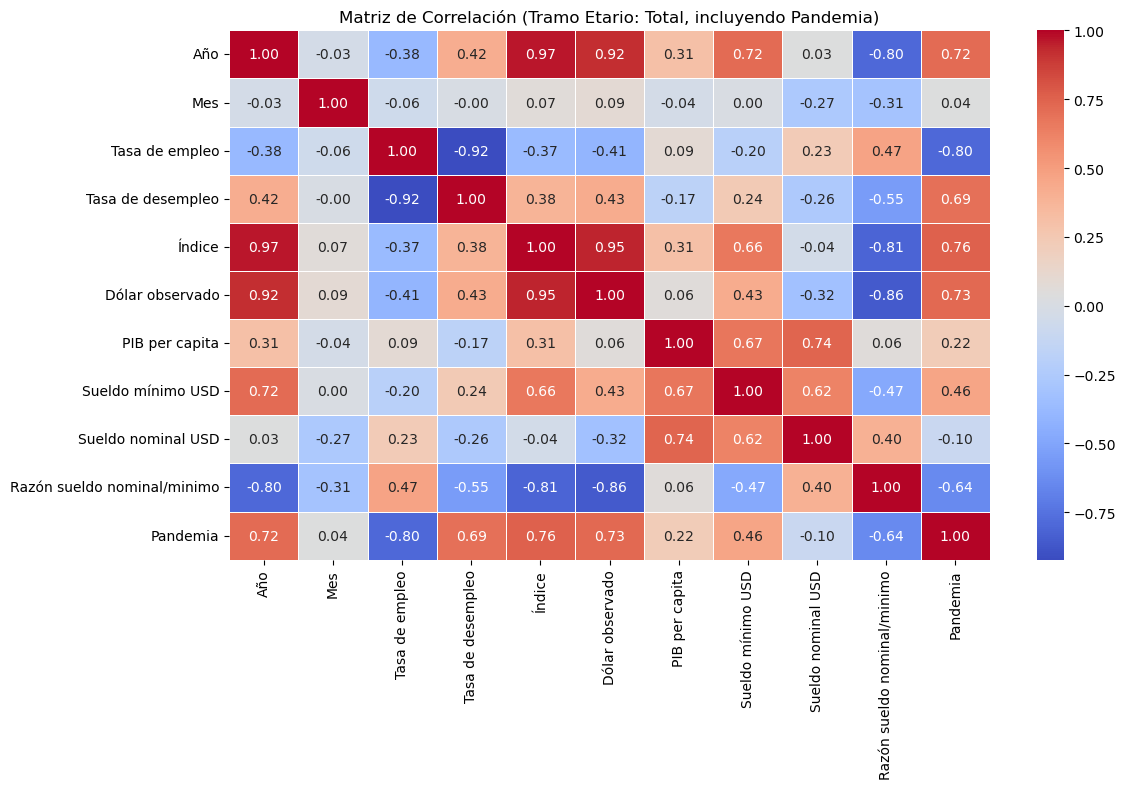

In [111]:
# Filtrar solo las filas donde el tramo etario sea "Total"
df_total = df_encoded[df_encoded["Tramo etario_Total"] == 1]

# Asegurar que la columna Pandemia esté presente y sea numérica (True -> 1, False -> 0)
if "Pandemia" in df_total.columns:
    df_total["Pandemia"] = df_total["Pandemia"].astype(int)

# Seleccionar solo columnas numéricas
df_total_numeric = df_total.select_dtypes(include="number")

# Calcular la matriz de correlación
correlation_matrix = df_total_numeric.corr()

# Visualizar con un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación (Tramo Etario: Total, incluyendo Pandemia)")
plt.tight_layout()
plt.show()

C:\Users\orteg\AppData\Local\Temp\ipykernel_19772\1399434126.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total["Pandemia"] = df_total["Pandemia"].astype(bool)


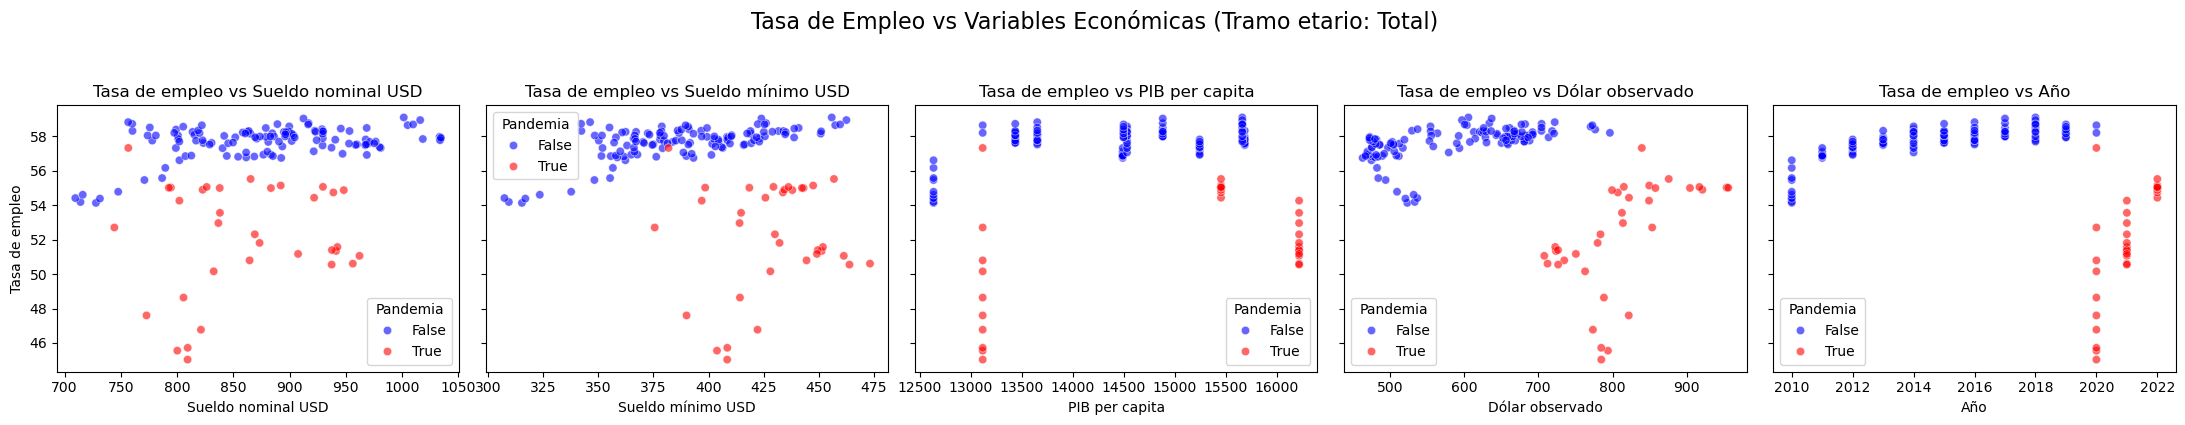

In [117]:
# Filtrar solo las filas donde el tramo etario sea "Total"
df_total = df_encoded[df_encoded["Tramo etario_Total"] == 1]

# Asegurarse que la columna Pandemia esté y sea booleana
if "Pandemia" in df_total.columns:
    df_total["Pandemia"] = df_total["Pandemia"].astype(bool)

# Columnas de interés
x_vars = [
    "Sueldo nominal USD",
    "Sueldo mínimo USD",
    "PIB per capita",
    "Dólar observado",
    "Año"
]
y_var = "Tasa de empleo"

# Eliminar valores faltantes (incluyendo pandemia)
df_plot = df_total[[y_var, "Pandemia"] + x_vars].dropna()

# Crear una fila de subplots
fig, axes = plt.subplots(1, len(x_vars), figsize=(22, 4), sharey=True)

# Crear un scatterplot por variable, coloreando por pandemia
for i, var in enumerate(x_vars):
    sns.scatterplot(data=df_plot, x=var, y=y_var, hue="Pandemia", ax=axes[i], alpha=0.6, palette={True: "red", False: "blue"})
    axes[i].set_title(f"{y_var} vs {var}")
    axes[i].legend().set_title("Pandemia")

# Ajustar presentación
plt.suptitle("Tasa de Empleo vs Variables Económicas (Tramo etario: Total)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


C:\Users\orteg\AppData\Local\Temp\ipykernel_19772\4011704982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total["Pandemia"] = df_total["Pandemia"].astype(bool)


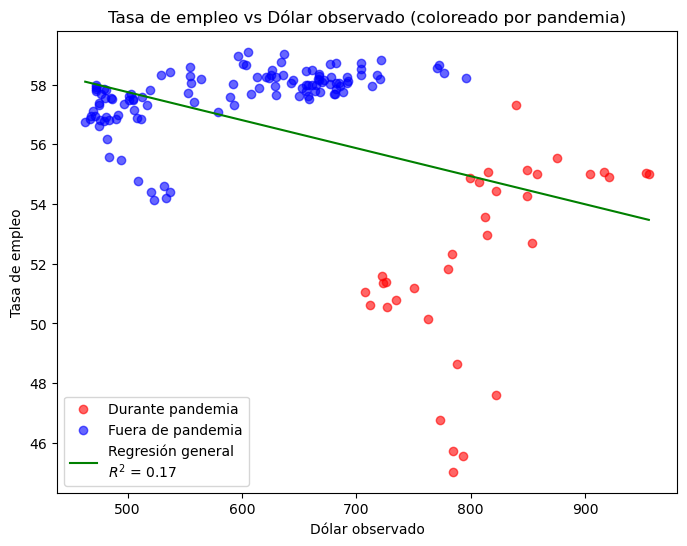

In [119]:
# Asegurar que 'Pandemia' está como columna booleana
df_total["Pandemia"] = df_total["Pandemia"].astype(bool)

# Seleccionar variables y eliminar filas con NA
df_reg = df_total[["Tasa de empleo", "Dólar observado", "Pandemia"]].dropna()

X = df_reg["Dólar observado"].values.reshape(-1, 1)
y = df_reg["Tasa de empleo"].values
pandemia = df_reg["Pandemia"].values

# Crear y entrenar modelo general
model = LinearRegression()
model.fit(X, y)
X_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_fit = model.predict(X_fit)

# Graficar con color por pandemia
plt.figure(figsize=(8, 6))
plt.scatter(X[pandemia], y[pandemia], color='red', alpha=0.6, label="Durante pandemia")
plt.scatter(X[~pandemia], y[~pandemia], color='blue', alpha=0.6, label="Fuera de pandemia")
plt.plot(X_fit, y_fit, color='green', label=f"Regresión general\n$R^2$ = {model.score(X, y):.2f}")
plt.xlabel("Dólar observado")
plt.ylabel("Tasa de empleo")
plt.title("Tasa de empleo vs Dólar observado (coloreado por pandemia)")
plt.legend()
plt.show()
